# New collaborations are driven by search for expertise

### Brief overview

One of the factors that we assume affect new collaboration occurrence is seeking expertise. This may include a statistician influencing a research on cancer treatment or a laboratory for data technologies trying to enter the field of recommender systems and finding authors publishing a lot on the topic of graph neural networks. We assume seeking expertise is one of the major reasons behind new collaborations. For each article, we will check all the author pair distances between related articles to see if there new collaborations have significantly larger distances between author pairs compared to existing collaborations.

**Key takeaways:**

### Imports & Global Variables

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import math
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from box import Box
from tqdm import tqdm
from datetime import date
from itertools import combinations
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance


from util.postgres import create_sqlalchemy_engine, query_polars

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_engine = create_sqlalchemy_engine(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
batch_size = 10000
n_top_closest = 5

# Set numpy random seed
np.random.seed(config.RANDOM_SEED)
sns.set_theme(style="whitegrid", palette="pastel")

## Querying the data

We query article embeddings, the related author pairs that hold the information about whether an author pair have already collaborated before publishing a given publication $p$ or not, and lastly we query the author article pairs that will allow us to see all the past articles of a particular author in order to understand their expertise in the field closely related to the given publication $p$.

In [3]:
%%time
with pg_engine.raw_connection().cursor() as cur:
    cur.execute("""
        SELECT article_id, article_embedding
        FROM g_included_article_embedding
    """)
    # Initialize the Polars DataFrame
    article_embedding_df: pl.DataFrame = pl.DataFrame()
    ix = 0
    # Fetch in chunks
    while True:
        rows = cur.fetchmany(size=batch_size)
        if not rows:
            break
        # Append the rows to the Polars DataFrame
        df_chunk = pl.DataFrame(rows, schema=["article_id", "article_embedding"], orient="row")
    
        # Concatenate chunk with the master DataFrame
        article_embedding_df = pl.concat([article_embedding_df, df_chunk], how="vertical")
        print(f"Rows fetched {batch_size} for batch {ix}")
        ix += 1

Rows fetched 10000 for batch 0
Rows fetched 10000 for batch 1
Rows fetched 10000 for batch 2
Rows fetched 10000 for batch 3
Rows fetched 10000 for batch 4
Rows fetched 10000 for batch 5
Rows fetched 10000 for batch 6
Rows fetched 10000 for batch 7
Rows fetched 10000 for batch 8
Rows fetched 10000 for batch 9
Rows fetched 10000 for batch 10
Rows fetched 10000 for batch 11
Rows fetched 10000 for batch 12
Rows fetched 10000 for batch 13
Rows fetched 10000 for batch 14
Rows fetched 10000 for batch 15
Rows fetched 10000 for batch 16
Rows fetched 10000 for batch 17
Rows fetched 10000 for batch 18
Rows fetched 10000 for batch 19
Rows fetched 10000 for batch 20
Rows fetched 10000 for batch 21
Rows fetched 10000 for batch 22
Rows fetched 10000 for batch 23
Rows fetched 10000 for batch 24
Rows fetched 10000 for batch 25
Rows fetched 10000 for batch 26
Rows fetched 10000 for batch 27
Rows fetched 10000 for batch 28
Rows fetched 10000 for batch 29
Rows fetched 10000 for batch 30
Rows fetched 10000

In [4]:
%%time
sql_query = f"""
SELECT f.article_id,
       f.author_id,
       f.co_author_id,
       f.is_new_author_pair,
       a.article_publication_dt
FROM fct_new_author_pair f
    INNER JOIN dim_article a 
        ON a.article_id = f.article_id
WHERE f.author_id IN (SELECT author_id FROM g_included_author)
    AND f.co_author_id IN (SELECT author_id FROM g_included_author)
"""
with pg_engine.connect() as conn:
    df_author_pair = query_polars(conn=conn, query_str=sql_query)

CPU times: user 11.4 s, sys: 3.75 s, total: 15.2 s
Wall time: 44.6 s


In [5]:
%%time
sql_query = f"""
SELECT DISTINCT article_id,
                author_id,
                article_publication_dt
FROM fct_collaboration
WHERE author_id IN (SELECT author_id FROM g_included_author)
ORDER BY article_publication_dt ASC
"""

with pg_engine.connect() as conn:
    df_collab = query_polars(conn=conn, query_str=sql_query)

CPU times: user 3.78 s, sys: 591 ms, total: 4.37 s
Wall time: 17.1 s


## Prepocessing for optimization

In [10]:
# Build a lookup dictionary for article embeddings
article_embeddings = {}
for row in tqdm(article_embedding_df.iter_rows(named=True)):
    article_id = row["article_id"]
    emb = row["article_embedding"]
    
    if isinstance(emb, list):
        emb = np.array(emb, dtype=np.float32)
    article_embeddings[article_id] = emb

354102it [01:17, 4542.40it/s]


In [11]:
# Build a lookup dictionary for author articles
author_articles_map = defaultdict(list)
for row in tqdm(df_collab.iter_rows(named=True)):
    author_id = row["author_id"]
    article_id = row["article_id"]
    article_publication_dt = row["article_publication_dt"]
    author_articles_map[author_id].append((article_id, article_publication_dt))

# Sort each author's articles by publication date to handle "before/after" queries quickly.
for author_id in author_articles_map:
    author_articles_map[author_id].sort(key=lambda x: x[1])  

973511it [00:07, 138147.87it/s]


In [12]:
# Build a dictionary to check new/existing author pairs
is_new_map = {}

for row in tqdm(df_author_pair.iter_rows(named=True)):
    article_id = row["article_id"]
    author_1_id = row["author_id"]
    author_2_id = row["co_author_id"]
    new_flag = row["is_new_author_pair"]
    
    key = (article_id, frozenset([author_1_id, author_2_id]))
    is_new_map[key] = new_flag

2199026it [00:30, 71863.70it/s] 


## Distances test

Given an article $p$ and the corresponding set of authors  $A_p$, we can separate the author pairs into two segments, where the following stands:
- segment $C_{new}$ represents the author pairs that have not yet collaborated:
	$\{c_x \in C_{new}; x = (a_i, a_j), a_i \in A_p, a_j \in A_p\}$, where authors $a_i$ and $a_j$ have not collaborated before publishing article $p$.
- segment $C_{existing}$ represents the author pairs that have already collaborated:
	$\{c_x \in C_{existing}; x = (a_i, a_j), a_i \in A_p, a_j \in A_p\}$, where authors $a_i$ and $a_j$ have already collaborated before publishing article $p$.

Having these segments, we now define the distance for a given author pair $x=(a_i, a_j)$ as $\delta_x=distance(a_i, a_j)$. Since we want to test whether the new collaboration was driven by search for expertise, we focus the distance function to article text embeddings of a given author pair. We do not want to confuse multiple research streams that a single author can have, hence we will cross-compare top N articles closest to given publication $p$ for both authors $a_i$ and $a_j$. We will apply cosine distance for cross-comparison at the article-pair level and use the maximum distance among the pairs to determine the distance at the author-pair level.

After evaluating all the distances between author pairs, we will Wasserstein-1 distance $w$, i.e. earth mover's distance, to determine the distance between the distributions of distances on author pairs with existing collaborations versus distances on author pairs that have not yet collaborated before. Additionally, we will use the Kolmogorov-Smirnov test to see if there exists a statistically significant difference between the distributions.

**NULL HYPOTHESIS** $H_0$: $w=0$


In [36]:
# Computing top-n closest articles for an author relative to article p
def get_top_k_closest_articles(article_id: int,
                               author_id: int,
                               article_publication_dt: date, 
                               k: int = 5) -> list:
    if article_id not in article_embeddings:
        return []
    
    emb_p = article_embeddings[article_id]
    
    # Collect all the author's articles, excluding all the publications happening after
    author_article_list_total = author_articles_map[author_id]
    author_article_list = [
        (article_i_id, article_i_publication_dt) for (article_i_id, article_i_publication_dt) in author_article_list_total
        if article_i_publication_dt < article_publication_dt
    ]

    # If no relevant articles for this author, return empty
    if not author_article_list:
        return []

    # Calculate the cosine distances to article p
    distances = []
    for (article_i_id, _) in author_article_list:
        if article_i_id not in article_embeddings:
            continue
        emb_a = article_embeddings[article_i_id]
        dist = cosine(emb_p, emb_a) 
        distances.append((article_i_id, dist))
    
    # Sort by distance ascending (closest first)
    distances.sort(key=lambda x: x[1])
    
    # Return top k
    return distances[:k]

In [24]:
# Computing the distance measure for each pair (a_i, a_j) given article p
#    1. We retrieve top-n closest articles from a_i and from a_j published before article p
#    2. We do a cross-comparison for all n x n pairs in embeddings and measure the maximum distance
def compute_pair_distance(article_id: int, 
                          author_i_id: int, 
                          author_j_id: int,
                          article_publication_dt: date) -> float:

    # Get closest articles
    top_n_i = get_top_k_closest_articles(article_id=article_id, 
                                         author_id=author_i_id, 
                                         article_publication_dt=article_publication_dt,
                                         k=n_top_closest)
    top_n_j = get_top_k_closest_articles(article_id=article_id, 
                                         author_id=author_j_id, 
                                         article_publication_dt=article_publication_dt,
                                         k=n_top_closest)
    
    # If for some reason we can't get any top articles:
    if not top_n_i or not top_n_j:
        return math.nan
    
    # Convert to just article IDs
    top_n_i_ids = [x[0] for x in top_n_i]
    top_n_j_ids = [x[0] for x in top_n_j]

    # Calculate distances between authors' articles
    distances_ij = []
    for article_i_id in top_n_i_ids:
        emb_i = article_embeddings.get(article_i_id)
        if emb_i is None:
            continue
        for article_j_id in top_n_j_ids:
            emb_j = article_embeddings.get(article_j_id)
            if emb_j is None:
                continue
            d_ij = cosine(emb_i, emb_j)
            distances_ij.append(d_ij)
    
    if len(distances_ij) == 0:
        return math.nan
    # Return the maximum distance as the author-pair level distance
    return float(np.max(distances_ij))

In [63]:
# Group df_collab by article_id
grouped = (df_collab
           .group_by("article_id", maintain_order=True).agg(
               [
                   pl.col("author_id").alias("authors_of_article"),
                   pl.col("article_publication_dt").first().alias("article_publication_dt"),
               ]
           )
           .filter(pl.col("article_id").is_in(article_embeddings.keys()))
          )

In [64]:
distances_new = []
distances_existing = []

author_pair_distances = []

# Iterate over articles
for row in tqdm(grouped.iter_rows(named=True)):
    article_id = row["article_id"]
    authors_of_article = row["authors_of_article"]
    article_publication_dt = row["article_publication_dt"]  
    
    # Iterate over all pair combinations among authors of article p
    for (author_i_id, author_j_id) in combinations(authors_of_article, 2):
        # Build the lookup key for is_new_map
        key = (article_id, frozenset([author_i_id, author_j_id]))
        if key not in is_new_map:
            # Skip if not found
            continue
        
        is_new = is_new_map[key]
        
        # Compute distance for a pair of authors
        pair_dist = compute_pair_distance(article_id, author_i_id, author_j_id, article_publication_dt)
        if math.isnan(pair_dist):
            # skip if we couldn't compute anything
            continue
        # Append to all author pair distances to be able to find a few examples
        author_pair_distances.append(dict(
            article_id=article_id,
            author_id=author_i_id,
            co_author_id=author_j_id,
            distance=pair_dist
        ))
        # Append to the appropriate distance list
        if is_new:
            distances_new.append(pair_dist)
        else:
            distances_existing.append(pair_dist)

354102it [2:20:35, 41.98it/s]  


In [65]:
# Sample the data so that we'll have a balanced dataset over collabroation types
n_new_collaborations = len(distances_new)
n_existing_collaborations = len(distances_existing)
min_collaboration_count = min(n_new_collaborations, n_existing_collaborations)
print(f'Number of new collaborations: {n_new_collaborations}')
print(f'Number of existing collaborations: {n_existing_collaborations}')

# Sample the dataframe to a balanced dataset
df_positive = pd.DataFrame([
    {'collaboration_type': 'new', 'distance': dst}
    for dst in distances_new
]).sample(n=min_collaboration_count)
df_negative = pd.DataFrame([
    {'collaboration_type': 'existing', 'distance': dst}
    for dst in distances_existing
]).sample(n=min_collaboration_count)

df_sampled = pd.concat([df_positive, df_negative])
df_sampled.head(5)

Number of new collaborations: 519882
Number of existing collaborations: 1412433


,collaboration_type,distance
219126,new,0.207302
40673,new,0.139849
464814,new,0.225996
311612,new,0.170264
59208,new,0.146568


new median: 0.17
existing median: 0.13


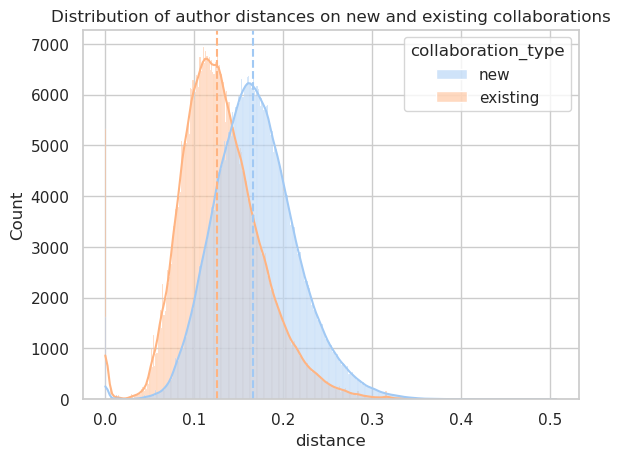

In [66]:
# Get palette
palette = sns.color_palette()

# Determine the unique collaboration types in the order they should appear
collaboration_order = df_sampled['collaboration_type'].unique()
# Draw histplot with KDEs
sns.histplot(data=df_sampled, 
             x='distance',
             kde=True,
             hue='collaboration_type',
             hue_order=collaboration_order
            )

# Add medians with matching colors in the correct order
palette = sns.color_palette(n_colors=len(collaboration_order))
medians = df_sampled.groupby('collaboration_type')['distance'].median()
for collaboration_type, color in zip(collaboration_order, palette):
    median = medians[collaboration_type]
    print(f'{collaboration_type} median: {median:.2f}')
    plt.axvline(median, linestyle='--', color=color, label=f'{collaboration_type} median')

plt.title("Distribution of author distances on new and existing collaborations")
plt.show()

In [67]:
# Extract distances for each collaboration type and convert to numpy arrays
distances_new = np.array(df_sampled[df_sampled['collaboration_type'] == 'new']['distance'], dtype=np.float32)
distances_existing = np.array(df_sampled[df_sampled['collaboration_type'] == 'existing']['distance'], dtype=np.float32)

# Calculate the Wasserstein distnace, i.e. earth mover distance
w_distance = wasserstein_distance(distances_new, distances_existing)
print(f"Wasserstein-1 distance (new vs existing): {w_distance:.4f}")

# Kolmogorov-Smirnov distribution equality test
ks_stat, p_value = ks_2samp(distances_new, distances_existing)
print(f"KS test stat: {round(ks_stat, 4)}, p-value: {round(p_value, 4)}")

Wasserstein-1 distance (new vs existing): 0.0387
KS test stat: 0.3603, p-value: 0.0


## (optional) Clustering test

Given an article $p$, we can cluster their authors into two clusters $C=\{c_f, c_o\}$, i.e. the cluster of the first author and the cluster of authors that significantly differ from the first author. We choose first author's cluster because we assume the first author is the most specified author in this field. Given our graph neural network models, these clusters will be based on author embeddings that relate to article text embeddings of the published articles and their previous collaborations. Since we assume convex clusters, we compare the centroids of the clusters $c_l$ and $c_o$ by evaluating the silhouette score. Next, we formulate the two collaboration datasets by distinguishing between new collaborations and existing collaborations: $D_{new}$ and $D_{existing}$.

Derived from the silhouette score, we calculate the silhouette coefficients $SC_{new}$ and $SC_{existing}$ for  $D_{new}$ and $D_{existing}$, respectively.

**NULL HYPOTHESIS** $H_0$: $SC_{new}$ <= $SC_{existing}$, or $SC_{new}<=0$

Note that since we have a very imbalanced set of articles in terms of research area, i.e. most articles are in medicine, machine learning and pharmacy, we have to dilute the embedding space.

**NOT IMPLEMENTED**

## Top biggest differences between authors

In [68]:
df_author_pair_distances = pd.DataFrame(author_pair_distances)
df_author_pair_distances.sort_values(by=['distance'], ascending=False).head(20)

,article_id,author_id,co_author_id,distance
4035,84903701937,15124716400,56187452900,0.507265
4033,84903701937,6603110785,15124716400,0.487093
4031,84903701937,35618885800,15124716400,0.486291
1127295,85085058237,55927168900,36101005700,0.451078
1127291,85085058237,15837900600,36101005700,0.451078
170909,84856035212,57203217666,15124716400,0.450402
922456,85061162271,8293136100,57201233781,0.447213
922263,85061118268,57201233781,8293136100,0.447213
145832,80053494504,7006689507,57221975472,0.446673
145835,80053494504,57221975472,7004528065,0.446673


In these top biggest differences between authors, we notice an article with [**ID 75849124815**](https://www.researchgate.net/publication/233775959_Transformations_of_Ethyl_2-Amino-4-2-ethoxy-2-oxoethylthioazole-5-carboxylate_into_5-Substituted_2-Amino-4-oxo-45-dihydrothiazolo54-cpyridine-7-carboxylates), that was written by 4 authors: 
1. [**Alen Albreht**](https://www.ki.si/o-institutu/imenik/3/) as the first author,
2. [**Jurij Svete**](https://uni-lj.academia.edu/JSvete),
3. [**Uroš Uršič**](https://www.researchgate.net/scientific-contributions/Uros-Ursic-2004209228) and
4. [**Branko Stanovnik**](https://www.sazu.si/clani/branko-stanovnik) as the lead author.

Digging deeper into all these authors, we quickly realize that dr. Alen Albreht focuses on the chemistry of nutrition, whereas this article falls under the umbrella of organic chemistry, a field to which professor Branko Stanovnik dedicated his career. His research group at the time included both professor Jurij Svete and dr. Uršič. It is possible that dr. Alen Albreht searched for expertise in organic chemistry from this research group thus creating a new collaboration group.

In [8]:
sql_query = f"""
SELECT a.author_id,
       a.author_name  as author,
       ca.author_name as co_author
FROM analitik.dim_author a
         CROSS JOIN analitik.dim_author ca
where ((a.author_id = '26326160800' and ca.author_id = '14032423200') or
       (a.author_id = '26326160800' and ca.author_id = '7006119716') or
       (a.author_id = '26326160800' and ca.author_id = '35583629600'))
"""
with pg_engine.connect() as conn:
    df_example = query_polars(conn=conn, query_str=sql_query)
df_example.head()

author_id,author,co_author
str,str,str
"""26326160800""","""Alen Albreht""","""Stanovnik B."""
"""26326160800""","""Alen Albreht""","""Svete J."""
"""26326160800""","""Alen Albreht""","""Ursic U."""


In [7]:
sql_query = f"""
SELECT *
FROM analitik.dim_article
WHERE article_id = '75849124815';
"""
with pg_engine.connect() as conn:
    df_example = query_polars(conn=conn, query_str=sql_query)
df_example.head()


article_id,article_doi,article_eid,article_title,article_journal_title,article_publication_dt,article_keywords,article_language,is_single_author_collaboration,is_internal_collaboration,is_external_collaboration,is_eutopia_collaboration
str,str,str,str,str,date,str,str,bool,bool,bool,bool
"""75849124815""","""10.3987/COM-09-11711""","""2-s2.0-75849124815""","""Transformations of ethyl 2-ami…","""Heterocycles""",2009-09-01,"""{heterocycles,transformations,…","""en""",false,true,false,false
